# 1. Gather Data
#### Convert the Imgs Text to actual text for pre-processing


Pytesseract docs: [link](https://pytesseract.readthedocs.io/en/latest/) <br>
Pytesseract PSM [link](https://pyimagesearch.com/2021/11/15/tesseract-page-segmentation-modes-psms-explained-how-to-improve-your-ocr-accuracy/) <br>
Pillow docs: [link](https://pillow.readthedocs.io/en/stable/)


In [2]:
%pip install pytesseract

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter
import os
import nltk
import json
from nltk.corpus import words
import matplotlib.pyplot as plt

nltk.download('words')

def filter_text(text):
    # print(text)
    # all_letters = set(string.ascii_letters)
    # text_letters = set(filter(str.isalpha, text))
    cleaned_text = text.replace('\n', '').replace('\f', '')
    return cleaned_text

def preprocess_image(image):
    # Apply sharpen and smooth filters
    image = image.filter(ImageFilter.SHARPEN)
    image = image.filter(ImageFilter.SMOOTH_MORE)

    # Increase DPI (dots per inch)
    image.info['dpi'] = (800, 800)

    return image

def enhance_contrast(image, factor):
    enhancer = ImageEnhance.Contrast(image)
    enhanced_image = enhancer.enhance(factor)
    return enhanced_image

def process_and_detect_word_art(image_path, sentences_set,labels_list, contrast_factor=10.0):
    # Open the image using Pillow
    image = Image.open(image_path)

    # Preprocess the image
    image = preprocess_image(image)

    # Enhance contrast
    image = enhance_contrast(image, contrast_factor)

    PSM_MODES:list = [3, 6, 7, 9]
    for psm in PSM_MODES:
        custom_config = f"--oem 3 --psm {psm}"
        text = pytesseract.image_to_string(image, config=custom_config)
        print(f"{image_path.split('/')[-1]} PSM Mode {psm} Output:")

        # ! Debugging: Display the image
        plt.imshow(image)
        plt.title(f"PSM Mode {psm} Output")
        print(text)
        plt.show()

        if filter_text(text):
            sentences_set.add(text)
            labels.append(psm)

# Define the directory containing your image files
DIR = '../data/imgs/'  # Update with the path to your DIR

# List all image files in the DIR
image_files = [file for file in os.listdir(DIR) if file.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

sentences_set = set()  # Set to store unique sentences
labels = list()  # Set to store unique sentences

# Process and detect word art for each image
for image_file in image_files:
    image_path = os.path.join(DIR, image_file)
    print(f"Processing: {image_path}")
    process_and_detect_word_art(image_path, sentences_set,labels)

# Write unique sentences to a single JSON file
output_json_filename = '../data/json/unique_sentences.json'
with open(output_json_filename, 'w') as json_file:
    cleaned_set = [s.replace('\n', '').replace('\f', '') for s in sentences_set]
    json.dump({"text": list(cleaned_set),"lables":labels}, json_file, indent=3)


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\athar\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Processing: ../data/imgs/Test_Capture_1.jpg
Test_Capture_1.jpg PSM Mode 3 Output:
Test_Capture_1.jpg PSM Mode 6 Output:
Test_Capture_1.jpg PSM Mode 7 Output:
Test_Capture_1.jpg PSM Mode 9 Output:
Processing: ../data/imgs/Test_Capture_2.jpg
Test_Capture_2.jpg PSM Mode 3 Output:
Test_Capture_2.jpg PSM Mode 6 Output:
Test_Capture_2.jpg PSM Mode 7 Output:
Test_Capture_2.jpg PSM Mode 9 Output:
Processing: ../data/imgs/Test_Capture_3.jpg
Test_Capture_3.jpg PSM Mode 3 Output:
Test_Capture_3.jpg PSM Mode 6 Output:
Test_Capture_3.jpg PSM Mode 7 Output:
Test_Capture_3.jpg PSM Mode 9 Output:
Processing: ../data/imgs/Test_Capture_4.jpg
Test_Capture_4.jpg PSM Mode 3 Output:
Test_Capture_4.jpg PSM Mode 6 Output:
Test_Capture_4.jpg PSM Mode 7 Output:
Test_Capture_4.jpg PSM Mode 9 Output:
Processing: ../data/imgs/Test_Capture_5.jpg
Test_Capture_5.jpg PSM Mode 3 Output:
Test_Capture_5.jpg PSM Mode 6 Output:
Test_Capture_5.jpg PSM Mode 7 Output:
Test_Capture_5.jpg PSM Mode 9 Output:
Processing: ../data/

# The Model Idea Copy Pasta

In [51]:
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import joblib
import json
from sklearn.model_selection import train_test_split

# Step 1: Load your textual data from a JSON file
json_filename = '../data/json/unique_sentences.json'
with open(json_filename, 'r') as json_file:
    data = json.load(json_file)

# Extract the advertisement texts from the JSON data
text_data = data['texts']


# Define sentiment labels: 0 for Not Effective, 1 for Somewhat Effective, 2 for Mildly Effective, 3 for Effective
labels = data['labels']  # Replace with actual sentiment labels

# Step 2: Set Parameters
max_words = 10000  # Maximum number of words in your vocabulary
max_sequence_length = 100  # Maximum length of input sequences
embedding_dim = 100  # Dimension of word embeddings
lstm_units = 64  # Number of LSTM units
dropout_rate = 0.2  # Dropout rate
num_classes = 4  # Number of sentiment classes

# Step 3: Text Tokenization and Padding
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Step 4: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)

# Step 5: Define the LSTM Model
model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=lstm_units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print a summary of the model's architecture
model.summary()

# Train the model with your data
# model.fit(X_train, y_train, epochs=YOUR_NUM_EPOCHS, validation_data=(X_test, y_test))

# Save the model as .h5 file
model.save("lstm_ad_sentiment_model.h5")

# Save the tokenizer as a .pkl file
joblib.dump(tokenizer, "tokenizer.pkl")

# Load the model and tokenizer for making predictions
loaded_model = load_model("lstm_ad_sentiment_model.h5")
loaded_tokenizer = joblib.load("tokenizer.pkl")

# Prepare new text for prediction
new_text = "A new advertisement text for analysis."

# Tokenize and pad the new text
new_text_sequence = loaded_tokenizer.texts_to_sequences([new_text])
new_text_padded = pad_sequences(new_text_sequence, maxlen=max_sequence_length)

# Make predictions
predictions = loaded_model.predict(new_text_padded)

# Interpret the predictions based on your sentiment class labels
# You can access predictions[0][0] to predictions[0][3] for the corresponding classes (0 to 3).


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           42240     
                                                                 
 dropout_1 (Dropout)         (None, 100, 64)           0         
                                                                 
 dense_1 (Dense)             (None, 100, 4)            260       
                                                                 
Total params: 1042500 (3.98 MB)
Trainable params: 1042500 (3.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


c:\Users\athar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 680ms/step


# Data Collection 1

### Dependencies

In [2]:
%pip install faker
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [151]:
import pandas as pd
import random
from datetime import datetime, timedelta
from faker import Faker

# Create an empty DataFrame
data = pd.DataFrame(columns=['number', 'advertisement_text', 'time', 'review', 'sentiment'])

# Define the possible sentiments
sentiments = ['positive', 'negative','mixed','neutral']

# Start with number 5 (assuming you already have rows with numbers 1 to 4)
current_number = 1

# Create a Faker object for generating random text
fake = Faker()

# Generate 50 more rows of data
for _ in range(500):
    # Generate random data
    advertisement_text = fake.sentence()
    time = (datetime(2023, 11, 5, 10, 30, 0) + timedelta(minutes=current_number * 15)).strftime('%Y-%m-%d %H:%M:%S')
    review = random.choice(sentiments)
    review_text = fake.paragraph(nb_sentences=random.randint(1, 4))
    data.loc[len(data)] = [current_number, advertisement_text, time, review_text, review]
    
    current_number += 1

# Save the generated data to a CSV file
data.to_csv('../data/dataset/sample_data.csv', index=False)


# The Real Model Thought

### Dependencies


In [57]:
%pip install tensorflow
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# LSTM

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 1.3906 - accuracy: 0.1228 - val_loss: 1.3789 - val_accuracy: 0.3333
Epoch 2/100
1/1 [==============================] - 0s 319ms/step - loss: 1.3700 - accuracy: 0.3860 - val_loss: 1.3708 - val_accuracy: 0.3333
Epoch 3/100
1/1 [==============================] - 0s 318ms/step - loss: 1.3494 - accuracy: 0.3860 - val_loss: 1.3632 - val_accuracy: 0.3333
Epoch 4/100
1/1 [==============================] - 0s 308ms/step - loss: 1.3261 - accuracy: 0.3860 - val_loss: 1.3583 - val_accuracy: 0.3333
Epoch 5/100
1/1 [==============================] - 0s 336ms/step - loss: 1.2972 - accuracy: 0.3860 - val_loss: 1.3685 - val_accuracy: 0.3333
Epoch 6/100
1/1 [==============================] - 0s 347ms/step - loss: 1.2726 - accuracy: 0.3860 - val_loss: 1.4329 - val_accuracy: 0.3333
Epoch 7/100
1/1 [==============================] - 0s 349ms/step - loss: 1.2612 - accuracy: 0.3860 - val_loss: 1.4752 - val_accuracy: 0.3333
Epoch 8/100
1/1 

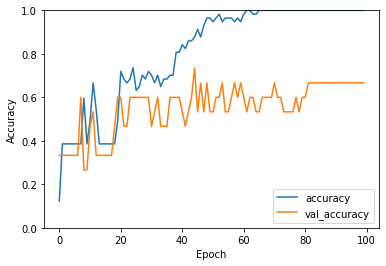

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 128)          21888     
                                                                 
 spatial_dropout1d_8 (Spati  (None, 100, 128)          0         
 alDropout1D)                                                    
                                                                 
 lstm_16 (LSTM)              (None, 100, 128)          131584    
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dense_30 (Dense)            (None, 4)                 260       
                                                                 
Total params: 203140 (793.52 KB)
Trainable params: 203140 (793.52 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [66]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load your dataset from a CSV file (adjust the file path accordingly)
data = pd.read_csv('../data/dataset/sample/sample_data.csv')

# Assuming the 'advertisement_text' column contains text data and the 'sentiment' column contains sentiment labels
texts = data['advertisement_text'].values
sentiments = data['sentiment'].values

# Encode the sentiment labels
label_encoder = LabelEncoder()
sentiments_encoded = label_encoder.fit_transform(sentiments)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(texts)

# Pad the sequences to have the same length
max_sequence_length = 100  # Adjust as needed
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Convert sentiments_encoded to one-hot encoding for multi-class classification
y = to_categorical(sentiments_encoded, num_classes=4)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Initialize lists to store training history
EPOCH = 100
BATCH_SIZE = 100
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

model.summary()


# CNN

In [ ]:
# Create a CNN model with more layers for higher precision
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length))
model.add(Conv1D(256, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Dropout for regularization
# Add another Dense layer
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
# Modify the output layer for sentiment classification
# Use 'softmax' activation for multi-class classification with four categories
model.add(Dense(4, activation='softmax'))

# Your output will be a vector with four values summing to 1, representing the probabilities for each sentiment category.
# For example, [0.2, 0.6, 0.1, 0.1] means 20% probability for positive, 60% for negative, 10% for neutral, and 10% for mixed sentiment.

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Initialize lists to store training history
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

model.summary()



# Save Model

In [67]:
# Custom model name
model_name = "custom_sentiment_model"

# Save the model with a custom name
model.save(f'../data/model/{model_name}_100ep.keras')

# Summary

### Training and Validation Accuracy

![Training and Validation Accuracy]
- The training accuracy (blue) shows the model's performance on the training data.
- The validation accuracy (red) represents the model's generalization to unseen data.

In an ideal scenario:
- The training accuracy should increase steadily with the number of epochs.
- The validation accuracy should also increase but may stabilize or decrease if overfitting occurs.

### Training and Validation Loss

![Training and Validation Loss]

- The training loss (blue) reflects how well the model minimizes the loss function on the training data.
- The validation loss (red) shows the model's ability to generalize.

In an ideal scenario:
- The training loss should decrease with epochs, indicating learning from the data.
- The validation loss should also decrease initially but may increase if overfitting occurs.

Interpreting the graphs:
- If both training and validation accuracy are increasing and close, the model is likely learning effectively.
- If validation accuracy lags significantly behind, overfitting may occur.
- A significant increase in validation loss while training loss is still decreasing could signal overfitting.
- Stable or decreasing validation loss is a positive sign of model generalization.

The goal is to balance high accuracy with minimal overfitting. Experiment with hyperparameters and model architectures for optimal results.


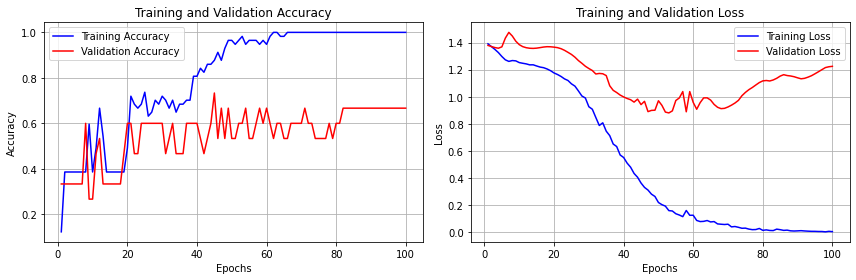

In [68]:
# Extract training and validation accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot performance graphs
epochs = range(1, len(train_accuracy) + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Testing

In [72]:
# Assuming you already have the trained model and necessary pre-processing in place

# Replace 'your_text_here' with the text you want to analyze
new_text = ["Optimize your home office setup and elevate your workout routine."]

# Tokenize and pad the new text
new_sequences = tokenizer.texts_to_sequences(new_text)
new_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)

# Make predictions
predictions = model.predict(new_sequences)

# Define a list of sentiment labels corresponding to your model's output order
sentiment_labels = ['Positive Sentiment', 'Negative Sentiment', 'Neutral Sentiment', 'Mixed Sentiment']

# Find the index with the maximum prediction value
predicted_index = np.argmax(predictions)

# Print the sentiment label based on the predicted index
print(new_text)
print(predictions)
print(sentiment_labels[predicted_index])


1/1 [==============================] - 0s 42ms/step
['Optimize your home office setup.']
[[1.2406723e-04 9.9847823e-01 4.1040761e-04 9.8730391e-04]]
Negative Sentiment
